In [2]:
import numpy as np
from tigramite.independence_tests.oracle_conditional_independence import OracleCI
from tigramite import plotting as tp
import itertools


### Links of the Causal Graph

Links can be initialized as a dictionary with a (key, value) pair for each variable $i$:

$\{i:[(j,0),(k,0)]\}$

where $i$ has $j,k$ as parents at lag 0.
In this excercise, all causal links are assumed to be at lag 0, i.e., we work with non-time-series data.

In [3]:
#For an unshielded collider links should look as follows:

links = {0 : [(1, 0), (2, 0)], 1: [], 2: []}

### Visualizing the Graph

Use the functionality of OracleCI to generate a graph corresponding to the links.

Note that the graph is mirror-symmetric around the diagonal, i.e., if $i$ is a parent of $j$ $\Rightarrow$ $j$ is a child of $i$

In [4]:
oracle = OracleCI(links=links)

graph = oracle.graph

print(graph[:,:,0])

[['' '<--' '<--']
 ['-->' '' '']
 ['-->' '' '']]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

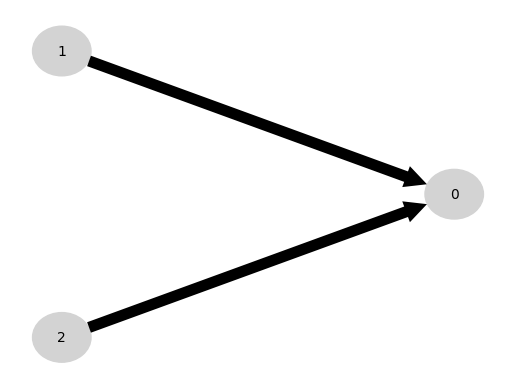

In [5]:
tp.plot_graph(graph = graph)

### Testing for Conditional Independence

Recall that the null hypothesis is (conditional) independence, so:

p-value == 1 $\Rightarrow$ independence

p-value == 0 $\Rightarrow$ dependence

In [6]:
# Test whether 1 and 2 are independent given Z = empty set versus Z = 0.
_, pval_1 = oracle.run_test(X = [(1,0)], Y = [(2,0)], Z = [])
_, pval_2 = oracle.run_test(X = [(1,0)], Y = [(2,0)], Z = [(0,0)])
pval_1, pval_2

(1.0, 0.0)

### Write a class to run the PC algorithm
with arguments
1. total number of variables and

2. oracle object

In [7]:
def get_adj(graph):
    N = len(graph)
    return dict([(j, list(np.where(graph[:,j] != 0)[0])) for j in range(N)])

In [8]:
def pcalg_skeleton(N,
                   ci_test=None,
                   verbosity=0):

#     N = X.shape[1]

    # Form complete graph
    graph = np.ones((N, N), dtype='int')

    # Remove self-links
    graph[range(N),range(N)] = 0

    # Define adjacency dictionary
    adj = get_adj(graph)

    # Define sepset
    sepset = dict([((i,j), []) for i in range(N) for j in range(N)])

    p = 0
    while(np.any([(i, j) for (i, j) in zip(*np.where(np.triu(graph)))
                 #if len(set(adj[j]) - set([i])) >= p])):
                  if len(set(adj[j]) - set([i])) >= p or len(set(adj[i]) - set([j])) >= p])):

        if verbosity > 0:
            print ("\n:::::::::::::::::::::::: p = %d" %p)

        for (i, j) in zip(*np.where(np.triu(graph))):
            if verbosity > 0:
                print ("\n\t%d -- %d" %(i, j))

            #conditions = list(itertools.combinations(list(set(adj[j]) - set([i])), p))
            conditions = list(itertools.combinations(list(set(list(set(adj[j]) - set([i]))+list(set(adj[i]) - set([j])))), p))
            if verbosity > 0:
                print ("\tIterate through conditions %s" %conditions)
            for q, S in enumerate(conditions):

                _, pval = ci_test.run_test(X = [(i,0)], Y = [(j,0)], Z = [(s, 0) for s in S])

                if verbosity > 0:
                    print ("\t\t%d _|_ %d | %s : %s " %(i, j, S, {1:'DEP', 0:'INDEPENDENT'}[pval == 0]))

                if pval > 0: # sig_level:
                    graph[i,j] = graph[j,i] = 0
                    sepset[(i,j)] = sepset[(j,i)] = list(S)
                    break

        if verbosity > 0:
            print("\nUpdated graph")
            print (graph)

        # Increase condition cardinality
        p += 1


        # Re-compute adj
        adj = get_adj(graph)

    return {'graph':graph,
            'sepset':sepset}

In [9]:
def pcalg_colliders(graph, sepset, verbosity=0):

    N = graph.shape[0]

    # Check symmetry
    if not np.all(graph==graph.transpose()):
        raise ValueError("Graph not symmetric")

    adj = get_adj(graph)

    # Find unshielded triples
    triples = []
    for i in range(N):
        for k in adj[i]:
            for j in adj[k]:
                if j > i and i != k and k != j:
                    if graph[i,j] == 0 and graph[j,i] == 0:
                        triples.append((i,k,j))

    for ikj in triples:
        i, k, j = ikj
        # print "triples ", ikj, sepset[(i,j)]
        if k not in sepset[(i,j)]:
            # print 'not in sep'
            graph[k,i] = 0
            graph[k,j] = 0

    if verbosity > 0:
        print("Updated graph")
        print (graph)

    return {'graph':graph,
            'sepset':sepset}

In [10]:
def pcalg_rules(graph, sepset, verbosity=0):

    N = graph.shape[0]

    def rule1(graph):
        # Find triples i --> k -- j with i -/- j
        adj = get_adj(graph)
        triples = []
        for k in range(N):
          for i in adj[k]:
            if k not in adj[i]:
              for j in adj[k]:
                if k in adj[j]:
                  if graph[i,j] == 0 and graph[j,i] == 0:
                    triples.append((i,k,j))

        # orient as i --> k --> j
        for ikj in triples:
            i,k,j = ikj
            graph[j,k] = 0

        return len(triples) > 0, graph

    def rule2(graph):
        # Find triples i --> k --> j with i -- j
        adj = get_adj(graph)
        triples = []
        for j in range(N):
          for k in adj[j]:
            if j not in adj[k]:
              for i in adj[k]:
                if k not in adj[i]:
                  if graph[i,j] == 1 and graph[j,i] == 1:
                    triples.append((i,k,j))

        # orient as i --> j
        for ikj in triples:
            i,k,j = ikj
            graph[j,i] = 0

        return len(triples) > 0, graph

    def rule3(graph):
        # Find chains i -- k --> j and  i -- l --> j with i -- j
        # and k -/- l
        adj = get_adj(graph)
        pairs = []
        for j in range(N):
           for i in adj[j]:
             if graph[j,i] == 1:
              for k in adj[j]:
                for l in adj[j]:
                    if (k != l and k != i and l != i and j not in adj[k] and j not in adj[l]
                       and graph[k,l] == 0 and graph[l,k] == 0):
                        if i in adj[l] and i in adj[k]:
                            if graph[k,i] == 1 and graph[l,i] == 1:
                                pairs.append((i,j))

        # orient as i --> j
        for ij in pairs:
            # print ij
            i,j = ij
            graph[j,i] = 0

        return len(pairs) > 0, graph

    graph_new = np.copy(graph)
    any1 = any2 = any3 = True
    while(any1 or any2 or any3):
        any1, graph_new = rule1(graph_new)
        any2, graph_new = rule2(graph_new)
        any3, graph_new = rule3(graph_new)


    if verbosity > 0:
        print("Updated graph")
        print (graph_new)

    return {'graph':graph_new,
            'sepset':sepset}

def skeleton(graph):
    skele = np.copy(graph + graph.transpose())
    return (skele > 0).astype('bool').astype('int')


In [29]:
encode_rel = lambda c: -1 if c == "<--" else 1 if c == "-->" else 0

class Graph:
    def __init__(self, num_variables: int):
        self.nodes = set(range(num_variables))
        self.edges = {p: self.nodes - set([p]) for p in self.nodes}
    
    def adj(self, p: int):
        return self.edges[p]
    
    def del_adj(self, p: int, q: int):
        if q in self.edges[p]:
            self.edges[p].remove(q)
        
    def __repr__(self) -> str:
        return "Nodes: {}, Edges: {}".format(self.nodes, self.edges)

def combinations(s: set, k: int):
    if k == 0:
        return [set()]
    if len(s) == 0:
        return []
    if len(s) == k:
        return [s]
    x = s.pop()
    s_copy = s.copy()
    s.add(x)
    return combinations(s_copy, k) + [set([x]).union(c) for c in combinations(s_copy, k - 1)]

class PCAlg:
    def __init__(self, num_variables: int, oracle_object: OracleCI, p: float = 0.05):
        self.num_variables = num_variables
        self.oracle_object = oracle_object
        self.p = p
        self.sepset = {}
        self.step1()
        self.step2()
        self.step3()
        
    def step1(self):
        self.graph = Graph(self.num_variables)
        
        for n_adj in range(self.num_variables - 1):
            for y in self.graph.nodes:
                adj_y = self.graph.edges[y]
                adj_yxs = [(x, adj_y - set([x])) for x in adj_y]
                adj_yxs_filtered = [(x, adj_yx) for x, adj_yx in adj_yxs if len(adj_yx) >= n_adj]
                adj_yxs_all_subsets = [(x, adj_yx_subset) for x, adj_yx in adj_yxs_filtered for adj_yx_subset in combinations(adj_yx, n_adj)]               
                for x, adj_y_subset in adj_yxs_all_subsets:
                    _, pval = self.oracle_object.run_test(
                        X = [(x, 0)], 
                        Y = [(y, 0)], 
                        Z = [(z, 0) for z in adj_y_subset]
                    )
                    if pval > self.p:
                        self.graph.del_adj(y, x)
                        self.sepset[(x, y)] = adj_y_subset
        return self
    
    def step2(self):
        triples = []
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                for z in self.graph.edges[y]:
                    if z == x or z in self.graph.edges[x]:
                        continue
                    triples.append((x, y, z))
        
        for x, y, z in triples:
            if y not in self.sepset[(x, z)]:
                self.graph.del_adj(y, x)
                self.graph.del_adj(y, z)
        return self
    
    def step3(self):
        while self.orient1() or self.orient2() or self.orient3():
            pass
        return self
    
    def orient1(self) -> bool:
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                if x in self.graph.edges[y]:
                    continue
                for z in self.graph.edges[y]:
                    if z == x:
                        continue
                    if z in self.graph.edges[x]:
                        continue
                    if y not in self.graph.edges[z]:
                        continue
                    self.graph.del_adj(z, y)        
                    return True
        return False
    
    def orient2(self) -> bool:              
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                if x in self.graph.edges[y]:
                    continue
                for z in self.graph.edges[y]:
                    if z == x:
                        continue
                    if y in self.graph.edges[z]:
                        continue
                    if x not in self.graph.edges[z] or z not in self.graph.edges[x]:
                        continue
                    self.graph.del_adj(z, x)
                    return True
        return False
    
    def orient3(self) -> bool:  
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                if x not in self.graph.edges[y]:
                    continue
                for z in self.graph.edges[x]:
                    if x not in self.graph.edges[z]:
                        continue
                    if z == y:
                       continue 
                    if z in self.graph.edges[y] or y in self.graph.edges[z]:
                        continue
                    for w in self.graph.edges[x]:
                        if x not in self.graph.edges[w]:
                            continue
                        if w == y or w == z:
                            continue 
                        if y in self.graph.edges[w] or z in self.graph.edges[w]:
                            continue
                        self.graph.del_adj(w, x)
                        return True
        return False

### Test your PC algorithm on this causal graph (aka Y-structure):
links =  {0: [], 1: [], 2: [(0,0), (1,0)], 3: [(2,0)]}

In [30]:
oracle = OracleCI(links= {0: [], 1: [], 2: [(0,0), (1,0)], 3: [(2,0)]})
verbosity = 0

node_pos={'x':[0, 1, 0.5, 0.5], 'y':[0, 0, 0.4, 1]}

Nodes: {0, 1, 2, 3}, Edges: {0: {2}, 1: {2}, 2: {3}, 3: set()}


(<Figure size 640x480 with 1 Axes>, <Axes: >)

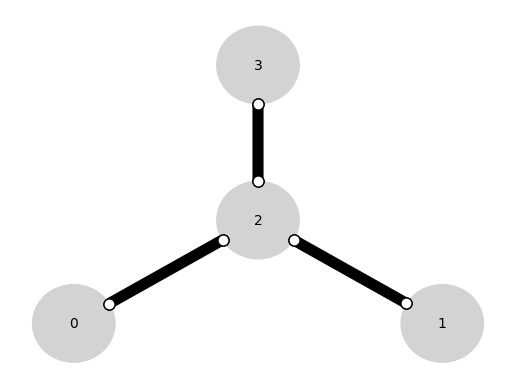

In [31]:
my_results = PCAlg(4, oracle)
print(my_results.graph)

skeleton_results = pcalg_skeleton(
   N=len(oracle.graph),
   ci_test=oracle,
   verbosity=verbosity)

tp.plot_graph(
    graph = skeleton_results['graph'],
    node_pos=node_pos)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

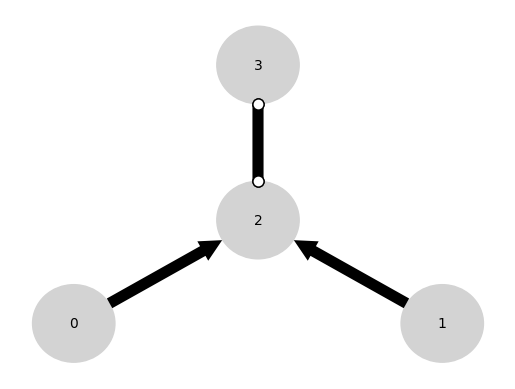

In [13]:
collider_results = pcalg_colliders(
    graph=skeleton_results['graph'],
    sepset=skeleton_results['sepset'],
    verbosity=verbosity)

tp.plot_graph(
    graph = collider_results['graph'],
    node_pos=node_pos)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

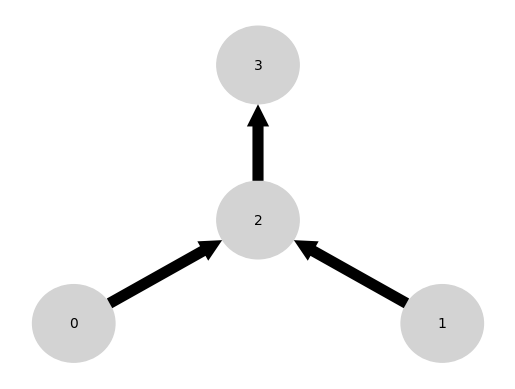

In [14]:
results = pcalg_rules(
    graph=collider_results['graph'],
    sepset=collider_results['sepset'],
    verbosity=verbosity)

tp.plot_graph(
    graph = results['graph'],
    node_pos=node_pos)


### Other Test Cases

Nodes: {0, 1, 2, 3, 4}, Edges: {0: {1, 4}, 1: {0, 2}, 2: {1, 3}, 3: {2, 4}, 4: {0, 3}}


(<Figure size 640x480 with 1 Axes>, <Axes: >)

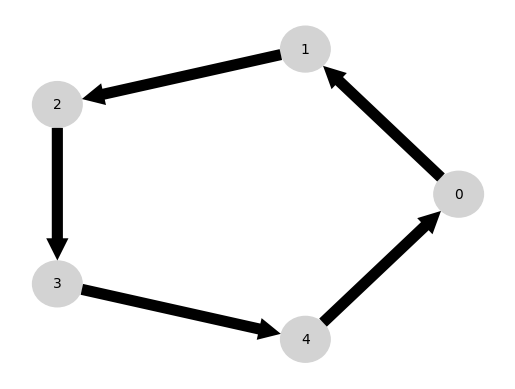

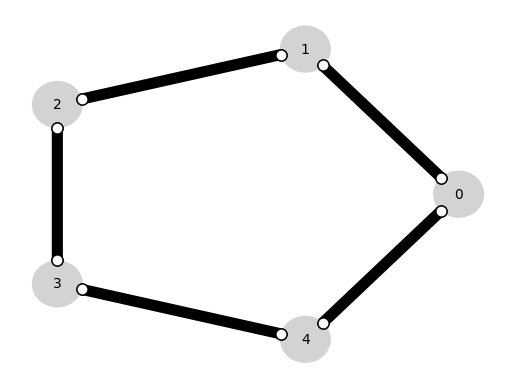

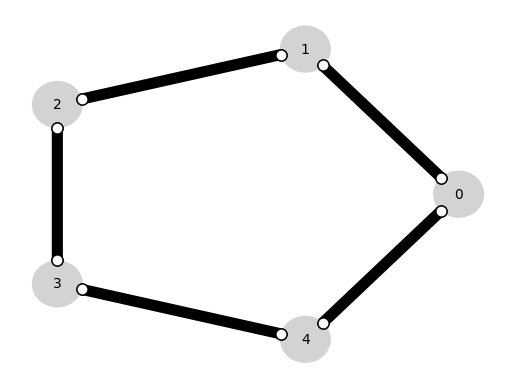

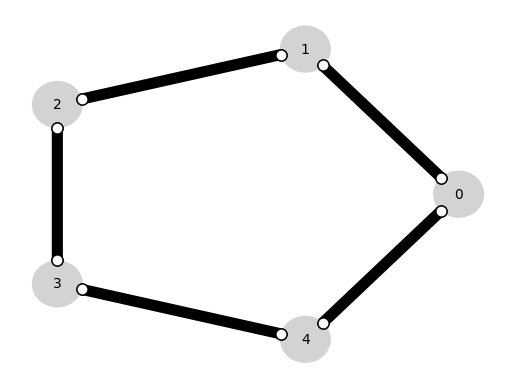

In [23]:
oracle = OracleCI(links={0: [(4,0)], 1: [(0,0)], 2: [(1,0)], 3: [(2,0)], 4: [(3,0)]})
true_graph = oracle.graph
tp.plot_graph(graph = true_graph)

my_results = PCAlg(5, oracle)
print(my_results.graph)

# skeleton phase
verbosity = 0
skeleton_results = pcalg_skeleton(
   N=len(oracle.graph),
   ci_test=oracle,
   verbosity=verbosity)
tp.plot_graph(
    graph = skeleton_results['graph'])

# collider and orientation rules
collider_results = pcalg_colliders(
    graph=skeleton_results['graph'],
    sepset=skeleton_results['sepset'],
    verbosity=verbosity)
tp.plot_graph(
    graph = collider_results['graph'])

results = pcalg_rules(
    graph=collider_results['graph'],
    sepset=collider_results['sepset'],
    verbosity=verbosity)

tp.plot_graph(
    graph = results['graph'])

Nodes: {0, 1, 2, 3, 4}, Edges: {0: {3, 4}, 1: {2, 4}, 2: {1, 3, 4}, 3: {0, 2, 4}, 4: {0, 1, 2, 3}}


(<Figure size 640x480 with 1 Axes>, <Axes: >)

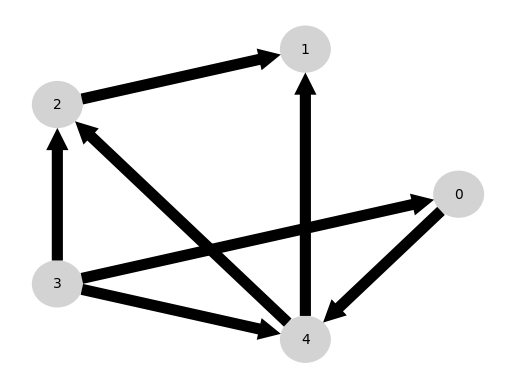

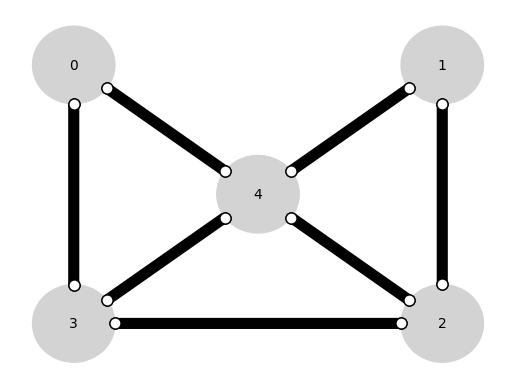

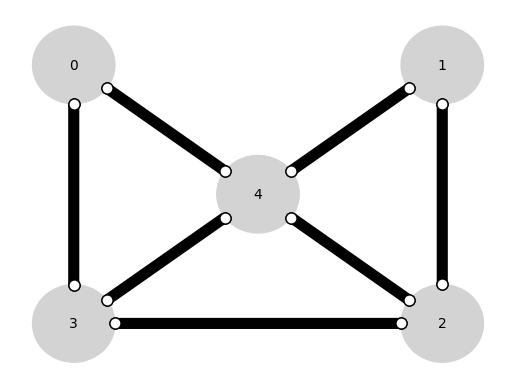

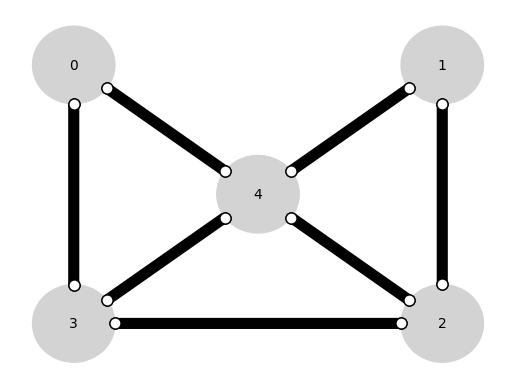

In [24]:
oracle = OracleCI(links={0: [(3,0)], 1: [(4,0),(2,0)], 2: [(3,0),(4,0)], 3: [], 4: [(0,0),(3,0)]})
true_graph = oracle.graph
tp.plot_graph(graph = true_graph)
node_pos={'x':[0, 1, 1, 0, 0.5], 'y':[1, 1, 0, 0, 0.5]}

my_results = PCAlg(5, oracle)
print(my_results.graph)

# Skeleton Phase
verbosity = 0
skeleton_results = pcalg_skeleton(
   N=len(oracle.graph),
   ci_test=oracle,
   verbosity=verbosity)
tp.plot_graph(
    graph = skeleton_results['graph'],
    node_pos = node_pos)

# Collider and orientation rules
collider_results = pcalg_colliders(
    graph=skeleton_results['graph'],
    sepset=skeleton_results['sepset'],
    verbosity=verbosity)
tp.plot_graph(
    graph = collider_results['graph'],
    node_pos = node_pos)

results = pcalg_rules(
    graph=collider_results['graph'],
    sepset=collider_results['sepset'],
    verbosity=verbosity)

tp.plot_graph(
    graph = results['graph'],
    node_pos = node_pos)

KeyError: (0, 3)

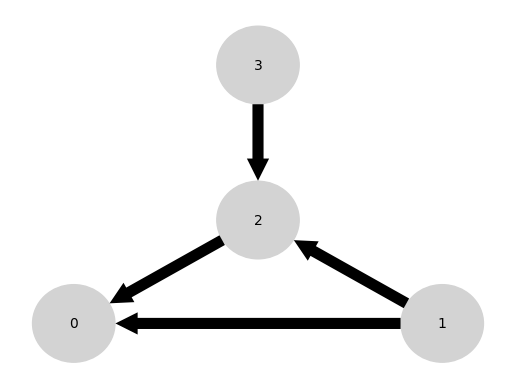

In [25]:
oracle = OracleCI(links= {0: [(1,0),(2,0)], 1: [], 2: [(3,0), (1,0)], 3: []})
verbosity = 0
node_pos={'x':[0, 1, 0.5, 0.5], 'y':[0, 0, 0.4, 1]}

true_graph = oracle.graph
tp.plot_graph(graph = true_graph, node_pos=node_pos)

my_results = PCAlg(4, oracle)
print(my_results.graph)

#skeleton phase
skeleton_results = pcalg_skeleton(
   N=len(oracle.graph),
   ci_test=oracle,
   verbosity=verbosity)
tp.plot_graph(
    graph = skeleton_results['graph'],
    node_pos=node_pos)


# Collider and orientation rules
collider_results = pcalg_colliders(
    graph=skeleton_results['graph'],
    sepset=skeleton_results['sepset'],
    verbosity=verbosity)
tp.plot_graph(
    graph = collider_results['graph'],
    node_pos=node_pos)

results = pcalg_rules(
    graph=collider_results['graph'],
    sepset=collider_results['sepset'],
    verbosity=verbosity)

tp.plot_graph(
    graph = results['graph'],
    node_pos=node_pos)